## Test Train 분리시 저압 흡착량 기준으로 Quantile

In [ ]:
import os
import datetime
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')

# ── 하이퍼파라미터 및 설정 ─────────────────────────────────
SEED = 42
BATCH_SIZE = 64
KFOLD_SPLIT = 5
HIDDEN_DIM = 64
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 100
PRINTEVERY = 5
RELATIVE = False   # 고압/저압 비율
Y_SCALE = False    # 비율 스케일링
X_SCALE = True    # 입력 스케일링
QUANTILE_LOW_ADS = True  # KEYPOINT 3: 데이터 분석 결과, 저압 흡착량(Low Ads)이 클수록 고압 흡착량(High Ads)도 큰 경향이 나타납니다.
# 특히 흡착량을 비율로 처리하면 극단값이 완화되므로, y값(High Ads)을 사전에 알 수 없는 상황에서도
# 입력 피처인 저압 흡착량(Low Ads)을 기준으로 고르게 샘플링하면, 학습 데이터의 대표성이 높아지고
# 결과적으로 예측 성능 향상에 긍정적인 영향을 미칩니다.

# ── 데이터 로드 및 전처리 ────────────────────────────────────
df = pd.read_csv("./01_Datasets/Ar_298K_5bar/Ar_298K_abs_0.5 bar_5.0 bar.csv")
X_all = df.iloc[:, 1:-1].values.astype(np.float32)
Y_all = df.iloc[:,    -1].values.astype(np.float32)
LOW_all = X_all[:, -1]

if X_SCALE:
    x_scaler = StandardScaler().fit(X_all[:, :])
if QUANTILE_LOW_ADS:
    # Step 1. LOW_all 기준으로 quantile bin 생성 (예: 5개 구간)
    num_bins = 10
    low_bins = pd.qcut(LOW_all, q=num_bins, labels=False, duplicates='drop')
    X_tr, X_te, Y_tr, Y_te, LOW_tr, LOW_te = train_test_split(
        X_all, Y_all, LOW_all,
        test_size=0.2,
        random_state=SEED,
        shuffle=True,
        stratify=low_bins  # 핵심 변경사항
    )
else: 
    X_tr, X_te, Y_tr, Y_te, LOW_tr, LOW_te = train_test_split(
    X_all, Y_all, LOW_all, test_size=0.2, random_state=SEED, shuffle=True
    )
# ── Dataset & Model ─────────────────────────────────────────
class GCMCDataset(Dataset):
    def __init__(self, X, Y, LOW):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
        self.LOW = torch.tensor(LOW, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.LOW[i]

class GCMCModel(nn.Module):
    def __init__(self, dim, hidden, drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, 1),
        )
    def forward(self, x): return self.net(x)

# ── K-Fold 학습/평가 ─────────────────────────────────────────
kf = KFold(n_splits=KFOLD_SPLIT, shuffle=True, random_state=SEED)
history_list = []
test_metrics = []
preds_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_tr), start=1):
    print(f"\n=== Fold {fold} ===")
    X_train, X_val = X_tr[tr_idx], X_tr[va_idx]
    Y_train, Y_val = Y_tr[tr_idx], Y_tr[va_idx]
    LOW_train, LOW_val = LOW_tr[tr_idx], LOW_tr[va_idx]

    if Y_SCALE:
        y_scaler = StandardScaler()
        ratio = (Y_train / LOW_train) if RELATIVE else Y_train
        y_scaler.fit(ratio.reshape(-1,1))

    def make_loader(Xa, Ya, La, shuffle):
        return DataLoader(GCMCDataset(Xa, Ya, La),
                          batch_size=BATCH_SIZE, shuffle=shuffle)

    train_dl = make_loader(X_train, Y_train, LOW_train, True)
    val_dl   = make_loader(X_val,   Y_val,   LOW_val,   False)
    test_dl  = make_loader(X_te,    Y_te,    LOW_te,    False)

    model = GCMCModel(X_train.shape[1], HIDDEN_DIM, DROPOUT_RATE).to(device)
    opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()

    fold_hist = []
    for ep in range(1, EPOCHS + 1):
        model.train()
        tloss = 0.0
        for xb, yb, lb in train_dl:
            xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
            if X_SCALE:
                # feats = xb[:, :-1].cpu().numpy()
                feats = x_scaler.transform(xb.cpu())  # 전체 xb 스케일링
                xb = torch.tensor(feats).float()
            y_rel = (yb / lb) if RELATIVE else yb
            if Y_SCALE:
                arr = y_rel.cpu().numpy().reshape(-1,1)
                y_rel = torch.from_numpy(y_scaler.transform(arr)).to(device).float()
            opt.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, y_rel)
            loss.backward()
            opt.step()
            tloss += loss.item()
        train_loss = tloss / len(train_dl)

        # validation
        model.eval()
        vloss = 0.0
        yt_list, yp_list = [], []
        with torch.no_grad():
            for xb, yb, lb in val_dl:
                xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
                if X_SCALE:
                    feats = x_scaler.transform(xb.cpu())  # 전체 xb 스케일링
                    xb = torch.tensor(feats).float()
                y_rel = (yb / lb) if RELATIVE else yb
                if Y_SCALE:
                    arr = y_rel.cpu().numpy().reshape(-1,1)
                    y_rel = torch.from_numpy(y_scaler.transform(arr)).to(device).float()
                preds = model(xb)
                vloss += loss_fn(preds, y_rel).item()

                pr = preds.cpu().numpy().reshape(-1,1)
                if Y_SCALE: pr = y_scaler.inverse_transform(pr)
                pr = pr.flatten()
                if RELATIVE: pr *= lb.cpu().numpy().flatten()
                yt_list.append(yb.cpu().numpy().flatten())
                yp_list.append(pr)

        val_loss = vloss / len(val_dl)
        y_true = np.concatenate(yt_list)
        y_pred = np.concatenate(yp_list)
        r2  = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        fold_hist.append((train_loss, val_loss, r2, mae, mse))

        if ep % PRINTEVERY == 0:
            print(f" Epoch {ep:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_R²={r2:.4f}")

    hist_df = pd.DataFrame(fold_hist, columns=[
        'train_loss','val_loss','val_r2','val_mae','val_mse'
    ])
    hist_df['fold'] = fold
    hist_df['epoch'] = hist_df.index + 1
    history_list.append(hist_df)

    # ---- Fold별 최종 Test 성능 출력 ----
    model.eval()
    tloss = 0.0
    yt_list, yp_list = [], []
    with torch.no_grad():
        for xb, yb, lb in test_dl:
            xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
            if X_SCALE:
                    feats = x_scaler.transform(xb.cpu())  # 전체 xb 스케일링
                    xb = torch.tensor(feats).float()
            y_rel = (yb / lb) if RELATIVE else yb
            if Y_SCALE:
                arr = y_rel.cpu().numpy().reshape(-1,1)
                y_rel = torch.from_numpy(y_scaler.transform(arr)).to(device).float()
            preds = model(xb)
            tloss += loss_fn(preds, y_rel).item()
            pr = preds.cpu().numpy().reshape(-1,1)
            if Y_SCALE: pr = y_scaler.inverse_transform(pr)
            pr = pr.flatten()
            if RELATIVE: pr *= lb.cpu().numpy().flatten()
            yt_list.append(yb.cpu().numpy().flatten())
            yp_list.append(pr)

    test_loss = tloss / len(test_dl)
    y_true_test = np.concatenate(yt_list)
    y_pred_test = np.concatenate(yp_list)
    r2_test  = r2_score(y_true_test, y_pred_test)
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    mse_test = mean_squared_error(y_true_test, y_pred_test)

    print("\n=== Final Test Performance ===")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test R²   : {r2_test:.4f}")
    print(f"Test MAE  : {mae_test:.4f}")
    print(f"Test MSE  : {mse_test:.4f}")

    test_metrics.append({
        'fold': fold,
        'test_loss': test_loss,
        'test_r2':   r2_test,
        'test_mae':  mae_test,
        'test_mse':  mse_test
    })
    preds_list.append(pd.DataFrame({
        'fold': fold,
        'y_true': y_true_test,
        'y_pred': y_pred_test
    }))

# ── CSV 저장 ───────────────────────────────────────────────
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
base = f"seed{SEED}_REL{RELATIVE}_bs{BATCH_SIZE}_kf{KFOLD_SPLIT}_hd{HIDDEN_DIM}_dr{int(DROPOUT_RATE*100)}_lr{LEARNING_RATE}"

train_val_df = pd.concat(history_list, ignore_index=True)
test_df      = pd.DataFrame(test_metrics)
preds_df     = pd.concat(preds_list, ignore_index=True)

train_val_df.to_csv(f"train_val_metrics_{base}_{ts}.csv", index=False)
test_df     .to_csv(f"test_metrics_{base}_{ts}.csv",      index=False)
preds_df    .to_csv(f"predictions_{base}_{ts}.csv",       index=False)

print("\nSaved CSVs with base:", base)


## KFOLD 시에도 저압 흡착량 기준 Stratify
*  왜 필요한가?
*  일반 KFold는 단순히 데이터를 무작위로 등분합니다.
* 그런데 저압 흡착량(LOW_ADS)이 고압 흡착량의 지표 역할을 하기 때문에,
* LOW_ADS 분포가 비슷하지 않은 fold 간에는 모델이 어떤 fold에서 잘 학습하고 어떤 fold에서 성능이 떨어지는 불균형이 생길 수 있습니다.
* 따라서, Train/Test Split 뿐만 아니라 Fold Split 시에도 LOW_ADS 기반으로 stratify하여 각 fold가 전체 데이터를 잘 대표하게 만드는 것이 바람직합니다.



In [ ]:
import os
import datetime
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')

# ── 하이퍼파라미터 및 설정 ─────────────────────────────────
SEED = 42
BATCH_SIZE = 64
KFOLD_SPLIT = 5
HIDDEN_DIM = 64
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 100
PRINTEVERY = 5
RELATIVE = False   # 고압/저압 비율
Y_SCALE = False    # 비율 스케일링
X_SCALE = True    # 입력 스케일링
QUANTILE_LOW_ADS = True  # KEYPOINT 3: 데이터 분석 결과, 저압 흡착량(Low Ads)이 클수록 고압 흡착량(High Ads)도 큰 경향이 나타납니다.
# 특히 흡착량을 비율로 처리하면 극단값이 완화되므로, y값(High Ads)을 사전에 알 수 없는 상황에서도
# 입력 피처인 저압 흡착량(Low Ads)을 기준으로 고르게 샘플링하면, 학습 데이터의 대표성이 높아지고
# 결과적으로 예측 성능 향상에 긍정적인 영향을 미칩니다.

# ── 데이터 로드 및 전처리 ────────────────────────────────────
df = pd.read_csv("./01_Datasets/Ar_298K_5bar/Ar_298K_abs_0.5 bar_5.0 bar.csv")
X_all = df.iloc[:, 1:-1].values.astype(np.float32)
Y_all = df.iloc[:,    -1].values.astype(np.float32)
LOW_all = X_all[:, -1]

if X_SCALE:
    x_scaler = StandardScaler().fit(X_all[:, :])
if QUANTILE_LOW_ADS:
    # Step 1. LOW_all 기준으로 quantile bin 생성 (예: 5개 구간)
    num_bins = 10
    low_bins = pd.qcut(LOW_all, q=num_bins, labels=False, duplicates='drop')
    X_tr, X_te, Y_tr, Y_te, LOW_tr, LOW_te = train_test_split(
        X_all, Y_all, LOW_all,
        test_size=0.2,
        random_state=SEED,
        shuffle=True,
        stratify=low_bins  # 핵심 변경사항
    )
else: 
    X_tr, X_te, Y_tr, Y_te, LOW_tr, LOW_te = train_test_split(
    X_all, Y_all, LOW_all, test_size=0.2, random_state=SEED, shuffle=True
    )
# ── Dataset & Model ─────────────────────────────────────────
class GCMCDataset(Dataset):
    def __init__(self, X, Y, LOW):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
        self.LOW = torch.tensor(LOW, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.LOW[i]

class GCMCModel(nn.Module):
    def __init__(self, dim, hidden, drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, 1),
        )
    def forward(self, x): return self.net(x)
from sklearn.model_selection import StratifiedKFold
# ── K-Fold 학습/평가 ─────────────────────────────────────────
# LOW_ADS 기준 quantile bin 생성
num_bins = 10
low_bins_for_kfold = pd.qcut(LOW_tr, q=num_bins, labels=False, duplicates='drop')

# StratifiedKFold 정의
skf = StratifiedKFold(n_splits=KFOLD_SPLIT, shuffle=True, random_state=SEED)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_tr, low_bins_for_kfold), start=1):
    print(f"\n=== Fold {fold} ===")
    X_train, X_val = X_tr[tr_idx], X_tr[va_idx]
    Y_train, Y_val = Y_tr[tr_idx], Y_tr[va_idx]
    LOW_train, LOW_val = LOW_tr[tr_idx], LOW_tr[va_idx]

    if Y_SCALE:
        y_scaler = StandardScaler()
        ratio = (Y_train / LOW_train) if RELATIVE else Y_train
        y_scaler.fit(ratio.reshape(-1,1))

    def make_loader(Xa, Ya, La, shuffle):
        return DataLoader(GCMCDataset(Xa, Ya, La),
                          batch_size=BATCH_SIZE, shuffle=shuffle)

    train_dl = make_loader(X_train, Y_train, LOW_train, True)
    val_dl   = make_loader(X_val,   Y_val,   LOW_val,   False)
    test_dl  = make_loader(X_te,    Y_te,    LOW_te,    False)

    model = GCMCModel(X_train.shape[1], HIDDEN_DIM, DROPOUT_RATE).to(device)
    opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()

    fold_hist = []
    for ep in range(1, EPOCHS + 1):
        model.train()
        tloss = 0.0
        for xb, yb, lb in train_dl:
            xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
            if X_SCALE:
                feats = x_scaler.transform(xb.cpu())  # 전체 xb 스케일링
                xb = torch.tensor(feats).float()
            y_rel = (yb / lb) if RELATIVE else yb
            if Y_SCALE:
                arr = y_rel.cpu().numpy().reshape(-1,1)
                y_rel = torch.from_numpy(y_scaler.transform(arr)).to(device).float()
            opt.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, y_rel)
            loss.backward()
            opt.step()
            tloss += loss.item()
        train_loss = tloss / len(train_dl)

        # validation
        model.eval()
        vloss = 0.0
        yt_list, yp_list = [], []
        with torch.no_grad():
            for xb, yb, lb in val_dl:
                xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
                if X_SCALE:
                    feats = x_scaler.transform(xb.cpu())  # 전체 xb 스케일링
                    xb = torch.tensor(feats).float()
                y_rel = (yb / lb) if RELATIVE else yb
                if Y_SCALE:
                    arr = y_rel.cpu().numpy().reshape(-1,1)
                    y_rel = torch.from_numpy(y_scaler.transform(arr)).to(device).float()
                preds = model(xb)
                vloss += loss_fn(preds, y_rel).item()

                pr = preds.cpu().numpy().reshape(-1,1)
                if Y_SCALE: pr = y_scaler.inverse_transform(pr)
                pr = pr.flatten()
                if RELATIVE: pr *= lb.cpu().numpy().flatten()
                yt_list.append(yb.cpu().numpy().flatten())
                yp_list.append(pr)

        val_loss = vloss / len(val_dl)
        y_true = np.concatenate(yt_list)
        y_pred = np.concatenate(yp_list)
        r2  = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        fold_hist.append((train_loss, val_loss, r2, mae, mse))

        if ep % PRINTEVERY == 0:
            print(f" Epoch {ep:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_R²={r2:.4f}")

    hist_df = pd.DataFrame(fold_hist, columns=[
        'train_loss','val_loss','val_r2','val_mae','val_mse'
    ])
    hist_df['fold'] = fold
    hist_df['epoch'] = hist_df.index + 1
    history_list.append(hist_df)

    # ---- Fold별 최종 Test 성능 출력 ----
    model.eval()
    tloss = 0.0
    yt_list, yp_list = [], []
    with torch.no_grad():
        for xb, yb, lb in test_dl:
            xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
            if X_SCALE:
                feats = x_scaler.transform(xb.cpu())  # 전체 xb 스케일링
                xb = torch.tensor(feats).float()
            y_rel = (yb / lb) if RELATIVE else yb
            if Y_SCALE:
                arr = y_rel.cpu().numpy().reshape(-1,1)
                y_rel = torch.from_numpy(y_scaler.transform(arr)).to(device).float()
            preds = model(xb)
            tloss += loss_fn(preds, y_rel).item()
            pr = preds.cpu().numpy().reshape(-1,1)
            if Y_SCALE: pr = y_scaler.inverse_transform(pr)
            pr = pr.flatten()
            if RELATIVE: pr *= lb.cpu().numpy().flatten()
            yt_list.append(yb.cpu().numpy().flatten())
            yp_list.append(pr)

    test_loss = tloss / len(test_dl)
    y_true_test = np.concatenate(yt_list)
    y_pred_test = np.concatenate(yp_list)
    r2_test  = r2_score(y_true_test, y_pred_test)
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    mse_test = mean_squared_error(y_true_test, y_pred_test)

    print("\n=== Final Test Performance ===")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test R²   : {r2_test:.4f}")
    print(f"Test MAE  : {mae_test:.4f}")
    print(f"Test MSE  : {mse_test:.4f}")

    test_metrics.append({
        'fold': fold,
        'test_loss': test_loss,
        'test_r2':   r2_test,
        'test_mae':  mae_test,
        'test_mse':  mse_test
    })
    preds_list.append(pd.DataFrame({
        'fold': fold,
        'y_true': y_true_test,
        'y_pred': y_pred_test
    }))

# ── CSV 저장 ───────────────────────────────────────────────
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
base = f"seed{SEED}_REL{RELATIVE}_bs{BATCH_SIZE}_kf{KFOLD_SPLIT}_hd{HIDDEN_DIM}_dr{int(DROPOUT_RATE*100)}_lr{LEARNING_RATE}"

train_val_df = pd.concat(history_list, ignore_index=True)
test_df      = pd.DataFrame(test_metrics)
preds_df     = pd.concat(preds_list, ignore_index=True)

train_val_df.to_csv(f"train_val_metrics_{base}_{ts}.csv", index=False)
test_df     .to_csv(f"test_metrics_{base}_{ts}.csv",      index=False)
preds_df    .to_csv(f"predictions_{base}_{ts}.csv",       index=False)

print("\nSaved CSVs with base:", base)



=== Fold 1 ===
 Epoch 005 | train_loss=0.0988 | val_loss=0.1034 | val_R²=0.8381
 Epoch 010 | train_loss=0.0794 | val_loss=0.0406 | val_R²=0.9365
 Epoch 015 | train_loss=0.0688 | val_loss=0.0448 | val_R²=0.9300
 Epoch 020 | train_loss=0.0572 | val_loss=0.0290 | val_R²=0.9544
 Epoch 025 | train_loss=0.0571 | val_loss=0.0320 | val_R²=0.9496
 Epoch 030 | train_loss=0.0516 | val_loss=0.0308 | val_R²=0.9518
 Epoch 035 | train_loss=0.0456 | val_loss=0.0244 | val_R²=0.9618
 Epoch 040 | train_loss=0.0531 | val_loss=0.0375 | val_R²=0.9414
 Epoch 045 | train_loss=0.0430 | val_loss=0.0215 | val_R²=0.9662
 Epoch 050 | train_loss=0.0384 | val_loss=0.0216 | val_R²=0.9662
 Epoch 055 | train_loss=0.0379 | val_loss=0.0250 | val_R²=0.9608
 Epoch 060 | train_loss=0.0380 | val_loss=0.0336 | val_R²=0.9472
 Epoch 065 | train_loss=0.0347 | val_loss=0.0226 | val_R²=0.9647
 Epoch 070 | train_loss=0.0361 | val_loss=0.0218 | val_R²=0.9658
 Epoch 075 | train_loss=0.0435 | val_loss=0.0211 | val_R²=0.9669
 Epoch 08

KeyboardInterrupt: 

## 낮은 비율의 데이터만 샘플링해서 MLP 학습후 성능 확인 (Train Test 나누기)

In [ ]:
import os
import datetime
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')

# ── 하이퍼파라미터 및 설정 ─────────────────────────────────
SEED = 42
BATCH_SIZE = 64
KFOLD_SPLIT = 5
HIDDEN_DIM = 64
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 100
PRINTEVERY = 5
RELATIVE = False   # 고압/저압 비율
Y_SCALE = False    # 비율 스케일링
X_SCALE = True    # 입력 스케일링
QUANTILE_LOW_ADS = True  # KEYPOINT 3: 데이터 분석 결과, 저압 흡착량(Low Ads)이 클수록 고압 흡착량(High Ads)도 큰 경향이 나타납니다.
# 특히 흡착량을 비율로 처리하면 극단값이 완화되므로, y값(High Ads)을 사전에 알 수 없는 상황에서도
# 입력 피처인 저압 흡착량(Low Ads)을 기준으로 고르게 샘플링하면, 학습 데이터의 대표성이 높아지고
# 결과적으로 예측 성능 향상에 긍정적인 영향을 미칩니다.

# ── 데이터 로드 및 전처리 ────────────────────────────────────
df = pd.read_csv("./01_Datasets/Ar_298K_5bar/Ar_298K_abs_0.5 bar_5.0 bar.csv")
X_all = df.iloc[:, 1:-1].values.astype(np.float32)
Y_all = df.iloc[:,    -1].values.astype(np.float32)
LOW_all = X_all[:, -1]

if X_SCALE:
    x_scaler = StandardScaler().fit(X_all[:, :])
if QUANTILE_LOW_ADS:
    # Step 1. LOW_all 기준으로 quantile bin 생성 (예: 5개 구간)
    num_bins = 10
    low_bins = pd.qcut(LOW_all, q=num_bins, labels=False, duplicates='drop')
    X_tr, X_te, Y_tr, Y_te, LOW_tr, LOW_te = train_test_split(
        X_all, Y_all, LOW_all,
        test_size=0.2,
        random_state=SEED,
        shuffle=True,
        stratify=low_bins  # 핵심 변경사항
    )
else: 
    X_tr, X_te, Y_tr, Y_te, LOW_tr, LOW_te = train_test_split(
    X_all, Y_all, LOW_all, test_size=0.2, random_state=SEED, shuffle=True
    )
# ── Dataset & Model ─────────────────────────────────────────
class GCMCDataset(Dataset):
    def __init__(self, X, Y, LOW):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
        self.LOW = torch.tensor(LOW, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.LOW[i]

class GCMCModel(nn.Module):
    def __init__(self, dim, hidden, drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, 1),
        )
    def forward(self, x): return self.net(x)
from sklearn.model_selection import StratifiedKFold
# ── K-Fold 학습/평가 ─────────────────────────────────────────
# LOW_ADS 기준 quantile bin 생성
num_bins = 10
low_bins_for_kfold = pd.qcut(LOW_tr, q=num_bins, labels=False, duplicates='drop')

# StratifiedKFold 정의
skf = StratifiedKFold(n_splits=KFOLD_SPLIT, shuffle=True, random_state=SEED)
for fold in range(1, 6):
    print(f"\n=== Fold {fold} ===")
    # Train 전체에서 15%만 무작위로 샘플링하되, LOW ADS 기준 stratify
    train_bins = pd.qcut(LOW_tr, q=10, labels=False, duplicates='drop')
    X_train, X_val, Y_train, Y_val, LOW_train, LOW_val = train_test_split(
        X_tr, Y_tr, LOW_tr,
        train_size=0.15/0.8,
        random_state=SEED + fold,  # fold마다 시드 다르게 설정
        shuffle=True,
        stratify=train_bins
    )
    if Y_SCALE:
        y_scaler = StandardScaler()
        ratio = (Y_train / LOW_train) if RELATIVE else Y_train
        y_scaler.fit(ratio.reshape(-1,1))

    def make_loader(Xa, Ya, La, shuffle):
        return DataLoader(GCMCDataset(Xa, Ya, La),
                          batch_size=BATCH_SIZE, shuffle=shuffle)

    train_dl = make_loader(X_train, Y_train, LOW_train, True)
    val_dl   = make_loader(X_val,   Y_val,   LOW_val,   False)
    test_dl  = make_loader(X_te,    Y_te,    LOW_te,    False)

    model = GCMCModel(X_train.shape[1], HIDDEN_DIM, DROPOUT_RATE).to(device)
    opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()

    fold_hist = []
    for ep in range(1, EPOCHS + 1):
        model.train()
        tloss = 0.0
        for xb, yb, lb in train_dl:
            xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
            if X_SCALE:
                feats = x_scaler.transform(xb.cpu())  # 전체 xb 스케일링
                xb = torch.tensor(feats).float()
            y_rel = (yb / lb) if RELATIVE else yb
            if Y_SCALE:
                arr = y_rel.cpu().numpy().reshape(-1,1)
                y_rel = torch.from_numpy(y_scaler.transform(arr)).to(device).float()
            opt.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, y_rel)
            loss.backward()
            opt.step()
            tloss += loss.item()
        train_loss = tloss / len(train_dl)

        # validation
        model.eval()
        vloss = 0.0
        yt_list, yp_list = [], []
        with torch.no_grad():
            for xb, yb, lb in val_dl:
                xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
                if X_SCALE:
                    feats = x_scaler.transform(xb.cpu())  # 전체 xb 스케일링
                    xb = torch.tensor(feats).float()
                y_rel = (yb / lb) if RELATIVE else yb
                if Y_SCALE:
                    arr = y_rel.cpu().numpy().reshape(-1,1)
                    y_rel = torch.from_numpy(y_scaler.transform(arr)).to(device).float()
                preds = model(xb)
                vloss += loss_fn(preds, y_rel).item()

                pr = preds.cpu().numpy().reshape(-1,1)
                if Y_SCALE: pr = y_scaler.inverse_transform(pr)
                pr = pr.flatten()
                if RELATIVE: pr *= lb.cpu().numpy().flatten()
                yt_list.append(yb.cpu().numpy().flatten())
                yp_list.append(pr)

        val_loss = vloss / len(val_dl)
        y_true = np.concatenate(yt_list)
        y_pred = np.concatenate(yp_list)
        r2  = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        fold_hist.append((train_loss, val_loss, r2, mae, mse))

        if ep % PRINTEVERY == 0:
            print(f" Epoch {ep:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_R²={r2:.4f}")

    hist_df = pd.DataFrame(fold_hist, columns=[
        'train_loss','val_loss','val_r2','val_mae','val_mse'
    ])
    hist_df['fold'] = fold
    hist_df['epoch'] = hist_df.index + 1
    history_list.append(hist_df)

    # ---- Fold별 최종 Test 성능 출력 ----
    model.eval()
    tloss = 0.0
    yt_list, yp_list = [], []
    with torch.no_grad():
        for xb, yb, lb in test_dl:
            xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
            if X_SCALE:
                feats = x_scaler.transform(xb.cpu())  # 전체 xb 스케일링
                xb = torch.tensor(feats).float()
            y_rel = (yb / lb) if RELATIVE else yb
            if Y_SCALE:
                arr = y_rel.cpu().numpy().reshape(-1,1)
                y_rel = torch.from_numpy(y_scaler.transform(arr)).to(device).float()
            preds = model(xb)
            tloss += loss_fn(preds, y_rel).item()
            pr = preds.cpu().numpy().reshape(-1,1)
            if Y_SCALE: pr = y_scaler.inverse_transform(pr)
            pr = pr.flatten()
            if RELATIVE: pr *= lb.cpu().numpy().flatten()
            yt_list.append(yb.cpu().numpy().flatten())
            yp_list.append(pr)

    test_loss = tloss / len(test_dl)
    y_true_test = np.concatenate(yt_list)
    y_pred_test = np.concatenate(yp_list)
    r2_test  = r2_score(y_true_test, y_pred_test)
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    mse_test = mean_squared_error(y_true_test, y_pred_test)

    print("\n=== Final Test Performance ===")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test R²   : {r2_test:.4f}")
    print(f"Test MAE  : {mae_test:.4f}")
    print(f"Test MSE  : {mse_test:.4f}")

    test_metrics.append({
        'fold': fold,
        'test_loss': test_loss,
        'test_r2':   r2_test,
        'test_mae':  mae_test,
        'test_mse':  mse_test
    })
    preds_list.append(pd.DataFrame({
        'fold': fold,
        'y_true': y_true_test,
        'y_pred': y_pred_test
    }))
    import gc 
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
# ── CSV 저장 ───────────────────────────────────────────────
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
base = f"seed{SEED}_REL{RELATIVE}_bs{BATCH_SIZE}_kf{KFOLD_SPLIT}_hd{HIDDEN_DIM}_dr{int(DROPOUT_RATE*100)}_lr{LEARNING_RATE}"

train_val_df = pd.concat(history_list, ignore_index=True)
test_df      = pd.DataFrame(test_metrics)
preds_df     = pd.concat(preds_list, ignore_index=True)

train_val_df.to_csv(f"train_val_metrics_{base}_{ts}.csv", index=False)
test_df     .to_csv(f"test_metrics_{base}_{ts}.csv",      index=False)
preds_df    .to_csv(f"predictions_{base}_{ts}.csv",       index=False)

print("\nSaved CSVs with base:", base)


## 낮은 비율의 데이터만 샘플링해서 MLP 학습후 성능 확인 (나머지를 모두 Test에)

In [ ]:
import os
import datetime
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')

# ── Settings ───────────────────────────────────────────
SEED = 42
BATCH_SIZE = 64
HIDDEN_DIM = 64
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 100
PRINTEVERY = 10
RELATIVE = False
X_SCALE = True
PATIENCE = 30
TRAIN_RATIO = 0.05  # Train 데이터 비율
NUM_TRIALS = 5         # 랜덤 시드 실험 횟수
prefix = "[Ar_05bar_5bar_RandomTrain_NOTESTSPLIT_5percent]"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(SEED)
torch.manual_seed(SEED)

# ── Data Load ──────────────────────────────────────────
df = pd.read_csv("./01_Datasets/Ar_298K_5bar/Ar_298K_abs_0.5 bar_5.0 bar.csv")
if "Unnamed: 0" in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
X_all = df.iloc[:, 1:-1].values.astype(np.float32)
Y_all = df.iloc[:, -1].values.astype(np.float32)
LOW_all = X_all[:, -1]

# Feature scaler
if X_SCALE:
    scaler_X = StandardScaler().fit(X_all)

# Dataset & Model definitions
class GCMCDataset(Dataset):
    def __init__(self, X, Y, LOW):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
        self.LOW = torch.tensor(LOW, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.LOW[i]

class GCMCModel(nn.Module):
    def __init__(self, dim, hidden, drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

# Training helper
def train_model(train_dl, val_dl):
    model = GCMCModel(X_all.shape[1], HIDDEN_DIM, DROPOUT_RATE).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()
    best_loss, patience = float('inf'), 0
    best_state = None
    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss = 0
        for xb, yb, lb in train_dl:
            xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
            if X_SCALE:
                xb = torch.tensor(scaler_X.transform(xb.cpu())).float().to(device)
            y_rel = yb / lb if RELATIVE else yb
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, y_rel)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb, lb in val_dl:
                xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
                if X_SCALE:
                    xb = torch.tensor(scaler_X.transform(xb.cpu())).float().to(device)
                y_rel = yb / lb if RELATIVE else yb
                val_loss += loss_fn(model(xb), y_rel).item()
        val_loss /= len(val_dl.dataset)
        if val_loss < best_loss:
            best_loss, best_state, patience = val_loss, model.state_dict(), 0
        else:
            patience += 1
        if patience >= PATIENCE:
            break
    model.load_state_dict(best_state)
    return model

# ── Random Train Trials ─────────────────────────────────
results = []
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
out_dir = f"{prefix}_{ts}"
os.makedirs(out_dir, exist_ok=True)

for trial in range(1, NUM_TRIALS+1):
    print(f"\n=== Trial {trial} ===")
    # 1) 랜덤 Train/Test split
    idx = np.arange(len(X_all))
    np.random.seed(SEED + trial)
    np.random.shuffle(idx)
    n_train = int(TRAIN_RATIO * len(idx))
    idx_train = idx[:n_train]
    idx_test = idx[n_train:]
    # 2) DataLoader
    train_ds = GCMCDataset(X_all[idx_train], Y_all[idx_train], LOW_all[idx_train])
    test_ds  = GCMCDataset(X_all[idx_test],  Y_all[idx_test],  LOW_all[idx_test])
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)
    # 3) Train
    model = train_model(train_dl, train_dl)
    # 4) Evaluate on remaining(test)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb, lb in test_dl:
            xb = xb.to(device);
            if X_SCALE:
                xb = torch.tensor(scaler_X.transform(xb.cpu())).float().to(device)
            out = model(xb).cpu().numpy().flatten()
            if RELATIVE:
                out = out * lb.numpy().flatten()
            y_true.extend(yb.numpy().flatten())
            y_pred.extend(out)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f"Test R2={r2:.4f}, MAE={mae:.4f}, MSE={mse:.4f}")
    results.append({'trial': trial, 'r2': r2, 'mae': mae, 'mse': mse})
    import gc 
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
# 5) Save results
res_df = pd.DataFrame(results)
res_df.to_csv(f"{out_dir}/random_train_results.csv", index=False)
print("\nAll trials completed.")


## 낮은 비율의 데이터만 샘플링해서 MLP 학습후 성능 확인 (Train Test 나누지않고, Quantile 샘플링 5번)

In [ ]:
import os
import datetime
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings('ignore')

# ── Settings ───────────────────────────────────────────
SEED = 42
BATCH_SIZE = 64
HIDDEN_DIM = 64
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 100
PATIENCE = 30
RELATIVE = False
X_SCALE = True
TRAIN_RATIO = 0.3    # Train 데이터 비율
NUM_TRIALS = 5         # 랜덤 시드 실험 횟수
NUM_BINS = 10          # 저압 흡착량 quantile 개수
prefix = "[Ar_05bar_5bar_RandomTrain_NOTESTSPLT_Quantile_30percent]"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(SEED)
torch.manual_seed(SEED)

# ── Data Load ──────────────────────────────────────────
df = pd.read_csv("./01_Datasets/Ar_298K_5bar/Ar_298K_abs_0.5 bar_5.0 bar.csv")
if "Unnamed: 0" in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
X_all = df.iloc[:, 1:-1].values.astype(np.float32)
Y_all = df.iloc[:, -1].values.astype(np.float32)
LOW_all = X_all[:, -1]
idx_all = np.arange(len(X_all))

# Feature scaler
if X_SCALE:
    scaler_X = StandardScaler().fit(X_all)

# Dataset & Model definitions
class GCMCDataset(Dataset):
    def __init__(self, X, Y, LOW):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
        self.LOW = torch.tensor(LOW, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.LOW[i]

class GCMCModel(nn.Module):
    def __init__(self, dim, hidden, drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

# Training helper
from tqdm import tqdm
def train_model(train_dl, val_dl):
    model = GCMCModel(X_all.shape[1], HIDDEN_DIM, DROPOUT_RATE).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.MSELoss()
    best_loss, patience = float('inf'), 0
    best_state = None
    for epoch in tqdm(range(1, EPOCHS+1)):
        model.train()
        total_loss = 0
        for xb, yb, lb in train_dl:
            xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
            if X_SCALE:
                xb = torch.tensor(scaler_X.transform(xb.cpu())).float().to(device)
            y_rel = yb / lb if RELATIVE else yb
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, y_rel)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb, lb in val_dl:
                xb, yb, lb = xb.to(device), yb.to(device), lb.to(device)
                if X_SCALE:
                    xb = torch.tensor(scaler_X.transform(xb.cpu())).float().to(device)
                y_rel = yb / lb if RELATIVE else yb
                val_loss += loss_fn(model(xb), y_rel).item()
        val_loss /= len(val_dl.dataset)
        if val_loss < best_loss:
            best_loss, best_state, patience = val_loss, model.state_dict(), 0
        else:
            patience += 1
        if patience >= PATIENCE:
            break
    model.load_state_dict(best_state)
    return model

# ── Quantile-based Random Train Trials ─────────────────
results = []
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
out_dir = f"{prefix}_{ts}"
os.makedirs(out_dir, exist_ok=True)

# Compute quantile bins for entire dataset
low_bins = pd.qcut(LOW_all, q=NUM_BINS, labels=False, duplicates='drop')

for trial in range(1, NUM_TRIALS+1):
    print(f"\n=== Trial {trial} ===")
    np.random.seed(SEED + trial)
    # Stratified quantile sampling for training indices
    idx_train = []
    per_bin = max(1, int(TRAIN_RATIO * len(idx_all) / NUM_BINS))
    for b in range(NUM_BINS):
        bin_idxs = np.where(low_bins == b)[0]
        if len(bin_idxs) > 0:
            select = np.random.choice(bin_idxs, size=min(per_bin, len(bin_idxs)), replace=False)
            idx_train.extend(select)
    idx_train = np.array(idx_train)
    # Ensure exact ratio if needed
    if len(idx_train) > int(TRAIN_RATIO * len(idx_all)):
        idx_train = np.random.choice(idx_train, int(TRAIN_RATIO * len(idx_all)), replace=False)
    idx_test = np.setdiff1d(idx_all, idx_train)

    # DataLoader
    train_ds = GCMCDataset(X_all[idx_train], Y_all[idx_train], LOW_all[idx_train])
    test_ds  = GCMCDataset(X_all[idx_test],  Y_all[idx_test],  LOW_all[idx_test])
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    # Train & Evaluate
    model = train_model(train_dl, train_dl)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb, lb in test_dl:
            xb = xb.to(device)
            if X_SCALE:
                xb = torch.tensor(scaler_X.transform(xb.cpu())).float().to(device)
            out = model(xb).cpu().numpy().flatten()
            if RELATIVE:
                out = out * lb.numpy().flatten()
            y_true.extend(yb.numpy().flatten())
            y_pred.extend(out)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f"Test R2={r2:.4f}, MAE={mae:.4f}, MSE={mse:.4f}")
    results.append({'trial': trial, 'r2': r2, 'mae': mae, 'mse': mse})
    import gc 
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
# Save results
res_df = pd.DataFrame(results)
res_df.to_csv(f"{out_dir}/quantile_train_results.csv", index=False)
print("\nAll trials completed.")


## Active Leaning 
* 불확실성 기반 샘플링시에도 QUantile 기반 샘플링을 병행하며 진행
* 먼저 적응할수 있도록 샘플링된 데이터 우선학습
* Test 셋미리 분리


In [ ]:
# Full implementation with Early Stopping, Stratified Quantile Sampling, and Uncertainty-based Active Learning
import os
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc

# ── Settings ───────────────────────────────────────────
SEED = 42
BATCH_SIZE = 64
HIDDEN_DIM = 64
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 30
INITIAL_RATIO = 0.01
SAMPLES_PER_ITER = 10
TARGET_RATIO = 0.15
MCD_N_SIMULATIONS = 20
BIN_WISE_COVERAGE = True
NUM_BINS = 10
RELATIVE = False
X_SCALE = True
QUANTILE_LOW_ADS = True

np.random.seed(SEED)
torch.manual_seed(SEED)

# ── Data Load ──────────────────────────────────────────
df = pd.read_csv("./01_Datasets/Ar_298K_5bar/Ar_298K_abs_0.5 bar_5.0 bar.csv")
X_all = df.iloc[:, 1:-1].values.astype(np.float32)
Y_all = df.iloc[:, -1].values.astype(np.float32)
LOW_all = X_all[:, -1]

if QUANTILE_LOW_ADS:
    low_bins = pd.qcut(LOW_all, q=NUM_BINS, labels=False, duplicates='drop')
    X_tr, X_te, Y_tr, Y_te, LOW_tr, LOW_te = train_test_split(
        X_all, Y_all, LOW_all,
        test_size=0.2,
        random_state=SEED,
        stratify=low_bins
    )
else:
    X_tr, X_te, Y_tr, Y_te, LOW_tr, LOW_te = train_test_split(
        X_all, Y_all, LOW_all, test_size=0.2, random_state=SEED, shuffle=True
    )

if X_SCALE:
    scaler_X = StandardScaler().fit(X_all)

class GCMCDataset(Dataset):
    def __init__(self, X, Y, LOW):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
        self.LOW = torch.tensor(LOW, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.LOW[i]

class GCMCModel(nn.Module):
    def __init__(self, dim, hidden, drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, 1))
    def forward(self, x): return self.net(x)

def mc_dropout_predict(model, X, n_simulations):
    model.train()
    predictions = []
    with torch.no_grad():
        for _ in range(n_simulations):
            predictions.append(model(X).cpu().numpy())
    predictions = np.array(predictions)
    return predictions.mean(axis=0), predictions.std(axis=0)

def stratified_quantile_sampling(low_values, idx_pool, n_samples):
    quantiles = pd.qcut(low_values[idx_pool], q=NUM_BINS, labels=False, duplicates='drop')
    idx_sampled = []
    per_bin = max(1, n_samples // NUM_BINS)
    for bin_id in np.unique(quantiles):
        bin_indices = idx_pool[quantiles == bin_id]
        sampled = np.random.choice(bin_indices, size=min(per_bin, len(bin_indices)), replace=False)
        idx_sampled.extend(sampled)
    return np.array(idx_sampled)

def train_with_early_stopping(model, optimizer, loss_fn, train_dl, val_dl):
    best_model = None
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb, lb in train_dl:
            feats = scaler_X.transform(xb)
            xb = torch.tensor(feats).float()
            y_rel = yb / lb if RELATIVE else yb
            preds = model(xb)
            loss = loss_fn(preds, y_rel)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss_total = 0
        with torch.no_grad():
            for xb, yb, lb in val_dl:
                feats = scaler_X.transform(xb)
                xb = torch.tensor(feats).float()
                y_rel = yb / lb if RELATIVE else yb
                preds = model(xb)
                val_loss_total += loss_fn(preds, y_rel).item()
        val_loss_avg = val_loss_total / len(val_dl.dataset)
        # if epoch % 40 == 0:
            # # print(f"[Epoch {epoch+1}] Val Loss: {val_loss_avg:.4f} | Best Loss: {best_loss:.4f}")
        if val_loss_avg < best_loss:
            best_loss = val_loss_avg
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= PATIENCE:
            # print(f"[Epoch {epoch+1}] Val Loss: {val_loss_avg:.4f} | Best Loss: {best_loss:.4f}")
            print("Early stopping triggered.")
            break
    model.load_state_dict(best_model)

n_initial = int(INITIAL_RATIO * len(X_all))
n_target = int(TARGET_RATIO * len(X_all))
idx_all = np.arange(len(X_tr))
np.random.shuffle(idx_all)
idx_labeled = stratified_quantile_sampling(LOW_tr, idx_all, n_initial)
idx_unlabeled = np.setdiff1d(idx_all, idx_labeled)

metrics_log = []
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(f"AL_{ts}/predictions", exist_ok=True)

model = GCMCModel(X_tr.shape[1], HIDDEN_DIM, DROPOUT_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

for iter in range((n_target - n_initial) // SAMPLES_PER_ITER + 1):
    print(f"\n=== Iteration {iter} ===")
    if iter > 0:
        print("[Uncertainty Estimation] Computing MC Dropout...")
        model.eval()
        unlabeled_ds = GCMCDataset(X_tr[idx_unlabeled], Y_tr[idx_unlabeled], LOW_tr[idx_unlabeled])
        unlabeled_dl = DataLoader(unlabeled_ds, BATCH_SIZE, False)
        uncertainties = []
        for xb, _, _ in unlabeled_dl:
            feats = scaler_X.transform(xb)
            xb = torch.tensor(feats).float()
            _, std = mc_dropout_predict(model, xb, MCD_N_SIMULATIONS)
            uncertainties.extend(std.flatten())
        uncertainties = np.array(uncertainties)
        half = SAMPLES_PER_ITER // 2
        idx_stratified = stratified_quantile_sampling(LOW_tr, idx_unlabeled, half)
        sorted_uncertainty_idx = np.argsort(uncertainties)[-half:]
        idx_uncertain = idx_unlabeled[sorted_uncertainty_idx]
        new_samples = np.concatenate([idx_stratified, idx_uncertain])
        idx_random = np.random.choice(idx_labeled, size=len(new_samples), replace=False)

        print("[Adaptation Phase] Short adaptation with new + old samples")
        short_ds = GCMCDataset(
            np.concatenate([X_tr[new_samples], X_tr[idx_random]]),
            np.concatenate([Y_tr[new_samples], Y_tr[idx_random]]),
            np.concatenate([LOW_tr[new_samples], LOW_tr[idx_random]])
        )
        short_dl = DataLoader(short_ds, BATCH_SIZE, True)

        val_ds = GCMCDataset(X_tr[idx_labeled], Y_tr[idx_labeled], LOW_tr[idx_labeled])
        val_dl = DataLoader(val_ds, BATCH_SIZE, False)

        train_with_early_stopping(model, optimizer, loss_fn, short_dl, val_dl)

        idx_labeled = np.concatenate([idx_labeled, new_samples])
        idx_unlabeled = np.setdiff1d(idx_unlabeled, new_samples)

    print("[Main Training Phase] Training on entire labeled set")
    full_ds = GCMCDataset(X_tr[idx_labeled], Y_tr[idx_labeled], LOW_tr[idx_labeled])
    full_dl = DataLoader(full_ds, BATCH_SIZE, True)

    val_ds = GCMCDataset(X_tr[idx_labeled], Y_tr[idx_labeled], LOW_tr[idx_labeled])
    val_dl = DataLoader(val_ds, BATCH_SIZE, False)

    train_with_early_stopping(model, optimizer, loss_fn, full_dl, val_dl)

    model.eval()
    X_test_tensor = torch.tensor(X_te, dtype=torch.float32)
    feats = scaler_X.transform(X_te)
    X_test_tensor = torch.tensor(feats).float()
    yt_test = Y_te
    mean_preds, _ = mc_dropout_predict(model, X_test_tensor, MCD_N_SIMULATIONS)
    yp_test = mean_preds.flatten() * LOW_te if RELATIVE else mean_preds.flatten()
    r2, mae, mse = r2_score(yt_test, yp_test), mean_absolute_error(yt_test, yp_test), mean_squared_error(yt_test, yp_test)
    print(f"[Evaluation] R2: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}")
    metrics_log.append({"iter": iter, "n_labeled": len(idx_labeled), "r2": r2, "mae": mae, "mse": mse})
    pd.DataFrame({"y_true": yt_test, "y_pred": yp_test}).to_csv(f"AL_{ts}/predictions/test_preds_iter_{iter}.csv", index=False)

    if len(idx_labeled) >= n_target:
        print("[Stopping] Reached target labeled data size.")
        break

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

pd.DataFrame(metrics_log).to_csv(f"AL_{ts}/active_learning_metrics.csv", index=False)
torch.save(model.state_dict(), f"AL_{ts}/final_model.pth")
print(f"[Complete] Results saved in AL_{ts}/")

## AL
* 처음에 저압흡착량 Quantile 기반으로 이니셜 셋 1%를 샘플링
* 이후 불확실성 기반으로 샘플링 해나가기.
* Test Set을 미리 분리하지 않고 샘플링하지 않은 모든 remaining이 매 이터레이션의 검증셋 

In [16]:
import os
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc

# ── Settings ───────────────────────────────────────────
SEED = 52
BATCH_SIZE = 64
HIDDEN_DIM = 64
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 30
INITIAL_RATIO = 0.01
SAMPLES_PER_ITER = 10
TARGET_RATIO = 0.30
MCD_N_SIMULATIONS = 20
BIN_WISE_COVERAGE = True
NUM_BINS = 10
RELATIVE = False
X_SCALE = True
QUANTILE_LOW_ADS = False
prefix = "[Ar_abs_298_0.5_1]"

np.random.seed(SEED)
torch.manual_seed(SEED)

####### GPU ##########
# ── Device & Backend ─────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("medium")
torch.backends.cudnn.benchmark = True
# ── Data Load ──────────────────────────────────────────
df = pd.read_csv("./Ar_298K_abs_0.5 bar_1.0 bar.csv")
if "Unnamed: 0" in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
X_all = df.iloc[:, 1:-1].values.astype(np.float32)
Y_all = df.iloc[:, -1].values.astype(np.float32)
LOW_all = X_all[:, -1]

# Optional stratified split for initialization only
if QUANTILE_LOW_ADS:
    low_bins = pd.qcut(LOW_all, q=NUM_BINS, labels=False, duplicates='drop')
    idx_all = np.arange(len(X_all))
    # stratify only initial sampling
else:
    idx_all = np.arange(len(X_all))

# Feature scaler
if X_SCALE:
    scaler_X = StandardScaler().fit(X_all)

# Dataset & Model definitions
class GCMCDataset(Dataset):
    def __init__(self, X, Y, LOW):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
        self.LOW = torch.tensor(LOW, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.LOW[i]

class GCMCModel(nn.Module):
    def __init__(self, dim, hidden, drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

def mc_dropout_predict(model, X, n_simulations):
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(n_simulations):
            preds.append(model(X).cpu().numpy())
    arr = np.array(preds)
    return arr.mean(axis=0), arr.std(axis=0)

def stratified_quantile_sampling(low_values, idx_pool, n_samples):
    quantiles = pd.qcut(low_values[idx_pool], q=NUM_BINS, labels=False, duplicates='drop')
    idx_sampled = []
    per_bin = max(1, n_samples // NUM_BINS)
    for bin_id in np.unique(quantiles):
        bin_idxs = idx_pool[quantiles == bin_id]
        sampled = np.random.choice(bin_idxs, size=min(per_bin, len(bin_idxs)), replace=False)
        idx_sampled.extend(sampled)
    return np.array(idx_sampled)

def train_with_early_stopping(model, optimizer, loss_fn, train_dl, val_dl):
    best_loss = float('inf')
    patience_ctr = 0
    best_state = None
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb, lb in train_dl:
            feats = scaler_X.transform(xb)
            xb = torch.tensor(feats).float()
            y_rel = yb / lb if RELATIVE else yb
            preds = model(xb)
            loss = loss_fn(preds, y_rel)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        total_val = 0
        with torch.no_grad():
            for xb, yb, lb in val_dl:
                feats = scaler_X.transform(xb)
                xb = torch.tensor(feats).float()
                y_rel = yb / lb if RELATIVE else yb
                total_val += loss_fn(model(xb), y_rel).item()
        avg_val = total_val / len(val_dl.dataset)
        if avg_val < best_loss:
            best_loss = avg_val
            best_state = model.state_dict()
            patience_ctr = 0
        else:
            patience_ctr += 1
        if patience_ctr >= PATIENCE:
            break
    if best_state is not None:
        model.load_state_dict(best_state)

# Initialize pools
n_samples_init = int(INITIAL_RATIO * len(X_all))
idx_labeled = stratified_quantile_sampling(LOW_all, idx_all, n_samples_init)
idx_unlabeled = np.setdiff1d(idx_all, idx_labeled)

# Logging setup
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
out_dir = f"{prefix}AL_{ts}"
os.makedirs(f"{out_dir}/predictions", exist_ok=True)
metrics = []

# Model, optimizer, loss\
model = GCMCModel(X_all.shape[1], HIDDEN_DIM, DROPOUT_RATE).to(device)
# Adam fused (파이토치/CUDA 조합에 따라 자동 fallback)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

# Active Learning loop
n_target = int(TARGET_RATIO * len(X_all))
max_iters = (n_target - len(idx_labeled)) // SAMPLES_PER_ITER + 1
for it in range(max_iters):
    print(f"Iteration {it}")
    # 1) Train on labeled set
    d_train = GCMCDataset(X_all[idx_labeled], Y_all[idx_labeled], LOW_all[idx_labeled])
    dl_train = DataLoader(d_train, batch_size=BATCH_SIZE, shuffle=True)
    dl_val   = DataLoader(d_train, batch_size=BATCH_SIZE, shuffle=False)
    train_with_early_stopping(model, optimizer, loss_fn, dl_train, dl_val)

    # 2) Evaluate on remaining pool
    model.eval()
    X_rem = torch.tensor(scaler_X.transform(X_all[idx_unlabeled])).float()
    y_true_rem = Y_all[idx_unlabeled]
    preds_mean, _ = mc_dropout_predict(model, X_rem, MCD_N_SIMULATIONS)
    y_pred_rem = preds_mean.flatten() * LOW_all[idx_unlabeled] if RELATIVE else preds_mean.flatten()
    r2 = r2_score(y_true_rem, y_pred_rem)
    mae = mean_absolute_error(y_true_rem, y_pred_rem)
    mse = mean_squared_error(y_true_rem, y_pred_rem)
    print(f"Remaining R2={r2:.4f}, MAE={mae:.4f}, MSE={mse:.4f}")
    metrics.append({"iter": it, "n_labeled": len(idx_labeled), "r2": r2, "mae": mae, "mse": mse})
    pd.DataFrame({"y_true": y_true_rem, "y_pred": y_pred_rem})\
        .to_csv(f"{out_dir}/predictions/rem_preds_iter_{it}.csv", index=False)

    # 3) Stopping condition
    if len(idx_labeled) >= n_target:
        break

    # 4) Query selection (uncertainty + stratified)
    print("[Query] MC Dropout Uncertainty...")
    unl_ds = GCMCDataset(X_all[idx_unlabeled], Y_all[idx_unlabeled], LOW_all[idx_unlabeled])
    unl_dl = DataLoader(unl_ds, batch_size=BATCH_SIZE, shuffle=False)
    uncertainties = []
    for xb, _, _ in unl_dl:
        xb_scaled = torch.tensor(scaler_X.transform(xb)).float()
        _, stds = mc_dropout_predict(model, xb_scaled, MCD_N_SIMULATIONS)
        uncertainties.extend(stds.flatten())
    uncertainties = np.array(uncertainties)
    half = SAMPLES_PER_ITER // 2
    strat_idx = stratified_quantile_sampling(LOW_all, idx_unlabeled, half)
    uncert_order = np.argsort(uncertainties)[-half:]
    uncert_idx = idx_unlabeled[uncert_order]
    new_idx = np.concatenate([strat_idx, uncert_idx])

    # 5) Update pools
    idx_labeled = np.concatenate([idx_labeled, new_idx])
    idx_unlabeled = np.setdiff1d(idx_unlabeled, new_idx)
    import gc 
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
# Save outputs
pd.DataFrame(metrics).to_csv(f"{out_dir}/active_learning_metrics.csv", index=False)
torch.save(model.state_dict(), f"{out_dir}/final_model.pth")
print("Done.")


Iteration 0
Remaining R2=0.9200, MAE=0.0528, MSE=0.0086
[Query] MC Dropout Uncertainty...
Iteration 1
Remaining R2=0.9101, MAE=0.0493, MSE=0.0083
[Query] MC Dropout Uncertainty...
Iteration 2
Remaining R2=0.9109, MAE=0.0520, MSE=0.0077
[Query] MC Dropout Uncertainty...
Iteration 3
Remaining R2=0.9323, MAE=0.0419, MSE=0.0055
[Query] MC Dropout Uncertainty...
Iteration 4
Remaining R2=0.9334, MAE=0.0411, MSE=0.0052
[Query] MC Dropout Uncertainty...
Iteration 5
Remaining R2=0.9504, MAE=0.0354, MSE=0.0037
[Query] MC Dropout Uncertainty...
Iteration 6
Remaining R2=0.9623, MAE=0.0313, MSE=0.0027
[Query] MC Dropout Uncertainty...
Iteration 7
Remaining R2=0.9632, MAE=0.0298, MSE=0.0025
[Query] MC Dropout Uncertainty...
Iteration 8
Remaining R2=0.9646, MAE=0.0276, MSE=0.0023
[Query] MC Dropout Uncertainty...
Iteration 9
Remaining R2=0.9705, MAE=0.0251, MSE=0.0019
[Query] MC Dropout Uncertainty...
Iteration 10
Remaining R2=0.9761, MAE=0.0220, MSE=0.0015
[Query] MC Dropout Uncertainty...
Iteration

KeyboardInterrupt: 

## GPU코드

In [18]:
import os
import datetime
import logging
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ── Settings ───────────────────────────────────────────
SEED = 52
BATCH_SIZE = 64
HIDDEN_DIM = 64
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 30
INITIAL_RATIO = 0.01
SAMPLES_PER_ITER = 10
TARGET_RATIO = 0.30
MCD_N_SIMULATIONS = 20
BIN_WISE_COVERAGE = True
NUM_BINS = 10
RELATIVE = False
X_SCALE = True
QUANTILE_LOW_ADS = True
prefix = "[Ar_298_abs_0.5_1]"

# ── Reproducibility ────────────────────────────────────
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

####### GPU / Backend ##########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("medium")
torch.backends.cudnn.benchmark = True

# ── Output directory & Logging setup ──────────────────
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
out_dir = f"{prefix}AL_{ts}"
os.makedirs(f"{out_dir}/predictions", exist_ok=True)

log_path = os.path.join(out_dir, "train.log")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler(log_path),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)
logger.info("Starting Active Learning run")

# ── Data Load ──────────────────────────────────────────
df = pd.read_csv("./Ar_298K_abs_0.5 bar_1.0 bar.csv")
if "Unnamed: 0" in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

X_all = df.iloc[:, 1:-1].values.astype(np.float32)
Y_all = df.iloc[:, -1].values.astype(np.float32)
LOW_all = X_all[:, -1]

idx_all = np.arange(len(X_all))

if X_SCALE:
    scaler_X = StandardScaler().fit(X_all)
    X_scaled = scaler_X.transform(X_all).astype(np.float32)
else:
    X_scaled = X_all

# ── Dataset & Model definitions ────────────────────────
class GCMCDataset(Dataset):
    def __init__(self, X, Y, LOW):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
        self.LOW = torch.tensor(LOW, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.LOW[i]

class GCMCModel(nn.Module):
    def __init__(self, dim, hidden, drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

# ── Functions ─────────────────────────────────────────
def mc_dropout_predict(model, X, n_simulations):
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(n_simulations):
            preds.append(model(X).cpu().numpy())
    arr = np.array(preds)
    return arr.mean(axis=0), arr.std(axis=0)

def stratified_quantile_sampling(low_values, idx_pool, n_samples):
    quantiles = pd.qcut(low_values[idx_pool], q=NUM_BINS, labels=False, duplicates='drop')
    idx_sampled = []
    per_bin = max(1, n_samples // NUM_BINS)
    for bin_id in np.unique(quantiles):
        bin_idxs = idx_pool[quantiles == bin_id]
        sampled = np.random.choice(bin_idxs, size=min(per_bin, len(bin_idxs)), replace=False)
        idx_sampled.extend(sampled)
    return np.array(idx_sampled)

def train_with_early_stopping(model, optimizer, loss_fn, train_dl, val_dl):
    best_loss = float('inf')
    patience_ctr = 0
    best_state = None
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb, lb in train_dl:
            feats = scaler_X.transform(xb)
            xb = torch.tensor(feats).float().to(device)
            yb = yb.to(device)
            lb = lb.to(device)
            y_rel = yb / lb if RELATIVE else yb
            preds = model(xb)
            loss = loss_fn(preds, y_rel)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        total_val = 0
        with torch.no_grad():
            for xb, yb, lb in val_dl:
                feats = scaler_X.transform(xb)
                xb = torch.tensor(feats).float().to(device)
                yb = yb.to(device)
                lb = lb.to(device)
                y_rel = yb / lb if RELATIVE else yb
                total_val += loss_fn(model(xb), y_rel).item()
        avg_val = total_val / len(val_dl.dataset)
        if avg_val < best_loss:
            best_loss = avg_val
            best_state = model.state_dict()
            patience_ctr = 0
        else:
            patience_ctr += 1
        if patience_ctr >= PATIENCE:
            break
    if best_state is not None:
        model.load_state_dict(best_state)

# ── Initialize pools ──────────────────────────────────
n_samples_init = int(INITIAL_RATIO * len(X_all))
idx_labeled = stratified_quantile_sampling(LOW_all, idx_all, n_samples_init)
idx_unlabeled = np.setdiff1d(idx_all, idx_labeled)

# ── Model, optimizer, loss ────────────────────────────
model = GCMCModel(X_all.shape[1], HIDDEN_DIM, DROPOUT_RATE).to(device)
if device.type == "cuda":
    try:
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, fused=True)
    except Exception:
        # PyTorch/드라이버/아키텍처 조합에 따라 fused 미지원일 수 있음
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
else:
    # CPU에서는 fused 미지원
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

# ── Active Learning loop ───────────────────────────────
metrics = []
n_target = int(TARGET_RATIO * len(X_all))
max_iters = (n_target - len(idx_labeled)) // SAMPLES_PER_ITER + 1

for it in range(max_iters):
    logger.info(f"Iteration {it} - labeled {len(idx_labeled)} / target {n_target}")

    # 1) Train
    d_train = GCMCDataset(X_all[idx_labeled], Y_all[idx_labeled], LOW_all[idx_labeled])
    dl_train = DataLoader(d_train, batch_size=BATCH_SIZE, shuffle=True)
    dl_val   = DataLoader(d_train, batch_size=BATCH_SIZE, shuffle=False)
    train_with_early_stopping(model, optimizer, loss_fn, dl_train, dl_val)

    # 2) Evaluate
    model.eval()
    X_rem = torch.tensor(scaler_X.transform(X_all[idx_unlabeled])).float().to(device)
    y_true_rem = Y_all[idx_unlabeled]
    preds_mean, _ = mc_dropout_predict(model, X_rem, MCD_N_SIMULATIONS)
    y_pred_rem = preds_mean.flatten() * LOW_all[idx_unlabeled] if RELATIVE else preds_mean.flatten()
    r2 = r2_score(y_true_rem, y_pred_rem)
    mae = mean_absolute_error(y_true_rem, y_pred_rem)
    mse = mean_squared_error(y_true_rem, y_pred_rem)
    logger.info(f"Eval Remaining - R2={r2:.4f}, MAE={mae:.4f}, MSE={mse:.4f}")

    metrics.append({"iter": it, "n_labeled": len(idx_labeled), "r2": r2, "mae": mae, "mse": mse})
    pd.DataFrame({"y_true": y_true_rem, "y_pred": y_pred_rem})\
        .to_csv(f"{out_dir}/predictions/rem_preds_iter_{it}.csv", index=False)

    if len(idx_labeled) >= n_target:
        break

    # 4) Query selection
    logger.info("[Query] MC Dropout Uncertainty...")
    unl_ds = GCMCDataset(X_all[idx_unlabeled], Y_all[idx_unlabeled], LOW_all[idx_unlabeled])
    unl_dl = DataLoader(unl_ds, batch_size=BATCH_SIZE, shuffle=False)
    uncertainties = []
    for xb, _, _ in unl_dl:
        xb_scaled = torch.tensor(scaler_X.transform(xb)).float().to(device)
        _, stds = mc_dropout_predict(model, xb_scaled, MCD_N_SIMULATIONS)
        uncertainties.extend(stds.flatten())
    uncertainties = np.array(uncertainties)
    half = SAMPLES_PER_ITER // 2
    strat_idx = stratified_quantile_sampling(LOW_all, idx_unlabeled, half)
    uncert_order = np.argsort(uncertainties)[-half:]
    uncert_idx = idx_unlabeled[uncert_order]
    new_idx = np.concatenate([strat_idx, uncert_idx])

    idx_labeled = np.concatenate([idx_labeled, new_idx])
    idx_unlabeled = np.setdiff1d(idx_unlabeled, new_idx)

# Save outputs
pd.DataFrame(metrics).to_csv(f"{out_dir}/active_learning_metrics.csv", index=False)
torch.save(model.state_dict(), f"{out_dir}/final_model.pth")
logger.info("Done. All results saved.")


2025-09-02 09:33:03,524 [INFO] Starting Active Learning run
2025-09-02 09:33:03,568 [INFO] Iteration 0 - labeled 80 / target 2530
2025-09-02 09:33:06,331 [INFO] Eval Remaining - R2=0.9200, MAE=0.0528, MSE=0.0086
2025-09-02 09:33:06,362 [INFO] [Query] MC Dropout Uncertainty...
2025-09-02 09:33:07,284 [INFO] Iteration 1 - labeled 95 / target 2530
2025-09-02 09:33:09,690 [INFO] Eval Remaining - R2=0.9101, MAE=0.0493, MSE=0.0083
2025-09-02 09:33:09,714 [INFO] [Query] MC Dropout Uncertainty...
2025-09-02 09:33:10,612 [INFO] Iteration 2 - labeled 110 / target 2530
2025-09-02 09:33:11,530 [INFO] Eval Remaining - R2=0.9109, MAE=0.0520, MSE=0.0077
2025-09-02 09:33:11,563 [INFO] [Query] MC Dropout Uncertainty...
2025-09-02 09:33:12,645 [INFO] Iteration 3 - labeled 125 / target 2530
2025-09-02 09:33:13,624 [INFO] Eval Remaining - R2=0.9323, MAE=0.0419, MSE=0.0055
2025-09-02 09:33:13,651 [INFO] [Query] MC Dropout Uncertainty...
2025-09-02 09:33:14,690 [INFO] Iteration 4 - labeled 140 / target 2530

KeyboardInterrupt: 

In [7]:
y_true_rem

array([1.7937174, 0.5079981, 5.602302 , ..., 6.078888 , 1.5581865,
       2.7899318], dtype=float32)

In [8]:
preds_mean

array([[ 791.17755],
       [1036.2155 ],
       [ 793.46716],
       ...,
       [ 917.702  ],
       [ 927.1577 ],
       [1260.3282 ]], dtype=float32)

In [9]:
X_rem

tensor([[-0.6847, -0.7489, -0.6699,  ..., -0.0193,  0.6535, -0.0563],
        [-0.1091, -0.1486, -0.0863,  ..., -0.0193,  0.6535, -0.0781],
        [ 0.6929, -0.6620,  0.5839,  ..., -0.0193, -1.5302, -0.0047],
        ...,
        [-0.4174, -0.0551, -0.4061,  ..., -0.0193, -1.5302, -0.0167],
        [-0.7345, -0.4748, -0.7227,  ..., -0.0193,  0.6535, -0.0622],
        [ 1.0636,  0.3936,  1.1005,  ..., -0.0193, -1.5302, -0.0601]])

## AL + 새로운 샘플 우선 적응하는 학습

In [13]:
import os
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc

# ── Settings ───────────────────────────────────────────
SEED = 52
BATCH_SIZE = 64
HIDDEN_DIM = 64
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 30
INITIAL_RATIO = 0.01
SAMPLES_PER_ITER = 10
TARGET_RATIO = 0.30
MCD_N_SIMULATIONS = 20
BIN_WISE_COVERAGE = True
NUM_BINS = 10
RELATIVE = False
X_SCALE = True
QUANTILE_LOW_ADS = False
prefix = "[Ar_05bar_5bar_AL_Priority]"

np.random.seed(SEED)
torch.manual_seed(SEED)

# ── Data Load ──────────────────────────────────────────
df = pd.read_csv("./01_Datasets/Ar_298K_5bar/Ar_298K_abs_0.5 bar_5.0 bar.csv")
if "Unnamed: 0" in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
X_all = df.iloc[:, 1:-1].values.astype(np.float32)
Y_all = df.iloc[:, -1].values.astype(np.float32)
LOW_all = X_all[:, -1]
idx_all = np.arange(len(X_all))

# Feature scaling
if X_SCALE:
    scaler_X = StandardScaler().fit(X_all)

# Dataset & Model definitions
class GCMCDataset(Dataset):
    def __init__(self, X, Y, LOW):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
        self.LOW = torch.tensor(LOW, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.LOW[i]

class GCMCModel(nn.Module):
    def __init__(self, dim, hidden, drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

# MC Dropout prediction
def mc_dropout_predict(model, X, n_sim):
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(n_sim): preds.append(model(X).cpu().numpy())
    arr = np.array(preds)
    return arr.mean(axis=0), arr.std(axis=0)

# Stratified sampling
def stratified_quantile_sampling(low_values, idx_pool, n_samples):
    quantiles = pd.qcut(low_values[idx_pool], q=NUM_BINS, labels=False, duplicates='drop')
    sampled = []
    per_bin = max(1, n_samples // NUM_BINS)
    for b in np.unique(quantiles):
        bin_idxs = idx_pool[quantiles == b]
        sampled.extend(np.random.choice(bin_idxs, min(per_bin, len(bin_idxs)), replace=False))
    return np.array(sampled)

# Early stopping train
def train_with_early_stopping(model, optimizer, loss_fn, train_dl, val_dl):
    best, patience = float('inf'), 0
    best_state = None
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb, lb in train_dl:
            feats = scaler_X.transform(xb)
            xb = torch.tensor(feats).float()
            y_rel = yb / lb if RELATIVE else yb
            loss = loss_fn(model(xb), y_rel)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        model.eval(); val_loss = 0
        with torch.no_grad():
            for xb, yb, lb in val_dl:
                xb = torch.tensor(scaler_X.transform(xb)).float()
                y_rel = yb / lb if RELATIVE else yb
                val_loss += loss_fn(model(xb), y_rel).item()
        val_loss /= len(val_dl.dataset)
        if val_loss < best: best, best_state, patience = val_loss, model.state_dict(), 0
        else: patience += 1
        if patience >= PATIENCE: break
    if best_state: model.load_state_dict(best_state)

# Initialize
n_init = int(INITIAL_RATIO * len(X_all))
idx_labeled = stratified_quantile_sampling(LOW_all, idx_all, n_init)
idx_unlabeled = np.setdiff1d(idx_all, idx_labeled)
metrics=[]
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
out_dir=f"{prefix}AL_{ts}"; os.makedirs(f"{out_dir}/predictions", exist_ok=True)
model = GCMCModel(X_all.shape[1], HIDDEN_DIM, DROPOUT_RATE)
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

n_target = int(TARGET_RATIO * len(X_all))
max_iters = (n_target - len(idx_labeled)) // SAMPLES_PER_ITER + 1
for it in range(max_iters):
    print(f"Iteration {it}")
    # Query & Adaptation for it>0
    if it>0:
        # 1) Sample
        unl = idx_unlabeled
        uncert=[]
        for xb,_,_ in DataLoader(GCMCDataset(X_all[unl],Y_all[unl],LOW_all[unl]),batch_size=BATCH_SIZE):
            xb_t = torch.tensor(scaler_X.transform(xb)).float()
            _, std = mc_dropout_predict(model, xb_t, MCD_N_SIMULATIONS)
            uncert.extend(std.flatten())
        uncert=np.array(uncert)
        half=SAMPLES_PER_ITER//2
        strat_idx = stratified_quantile_sampling(LOW_all, unl, half)
        top_idx = unl[np.argsort(uncert)[-half:]]
        new_idx = np.concatenate([strat_idx, top_idx])
        # 2) Adaptation: prioritize new
        mix_old = np.random.choice(idx_labeled, size=half, replace=False)
        adapt_idx = np.concatenate([new_idx, mix_old])
        adapt_ds = GCMCDataset(X_all[adapt_idx], Y_all[adapt_idx], LOW_all[adapt_idx])
        adapt_dl = DataLoader(adapt_ds,BATCH_SIZE,shuffle=True)
        val_dl  = DataLoader(GCMCDataset(X_all[idx_labeled],Y_all[idx_labeled],LOW_all[idx_labeled]),BATCH_SIZE)
        train_with_early_stopping(model, opt, loss_fn, adapt_dl, val_dl)
        # 3) Update pools
        idx_labeled = np.concatenate([idx_labeled, new_idx])
        idx_unlabeled = np.setdiff1d(idx_unlabeled, new_idx)
    # Main training
    ds = GCMCDataset(X_all[idx_labeled], Y_all[idx_labeled], LOW_all[idx_labeled])
    dl  = DataLoader(ds, BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(ds, BATCH_SIZE)
    train_with_early_stopping(model, opt, loss_fn, dl, val_dl)
    # Evaluate
    model.eval()
    rem = idx_unlabeled
    Xr = torch.tensor(scaler_X.transform(X_all[rem])).float()
    yp,_ = mc_dropout_predict(model, Xr, MCD_N_SIMULATIONS)
    yp = yp.flatten() if not RELATIVE else yp.flatten()*LOW_all[rem]
    r2 = r2_score(Y_all[rem], yp)
    mae = mean_absolute_error(Y_all[rem], yp)
    print(f"Remaining R2={r2:.4f}, MAE={mae:.4f}, MSE={mse:.4f}")
    metrics.append({"iter":it, "n_labeled":len(idx_labeled), "r2":r2, "mae":mae})
    pd.DataFrame({"y_true":Y_all[rem],"y_pred":yp})\
      .to_csv(f"{out_dir}/predictions/rem_preds_iter_{it}.csv",index=False)
# Save
    import gc 
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
pd.DataFrame(metrics).to_csv(f"{out_dir}/active_learning_metrics.csv", index=False)
torch.save(model.state_dict(),f"{out_dir}/final_model.pth")
print("Done.")


Iteration 0
Remaining R2=0.7960, MAE=0.1966, MSE=0.0083
Iteration 1
Remaining R2=0.8497, MAE=0.1753, MSE=0.0083
Iteration 2
Remaining R2=0.8764, MAE=0.1573, MSE=0.0083
Iteration 3
Remaining R2=0.8929, MAE=0.1443, MSE=0.0083
Iteration 4
Remaining R2=0.8992, MAE=0.1386, MSE=0.0083
Iteration 5
Remaining R2=0.9082, MAE=0.1285, MSE=0.0083
Iteration 6
Remaining R2=0.9162, MAE=0.1181, MSE=0.0083
Iteration 7
Remaining R2=0.9190, MAE=0.1136, MSE=0.0083
Iteration 8
Remaining R2=0.9097, MAE=0.1212, MSE=0.0083
Iteration 9
Remaining R2=0.9192, MAE=0.1111, MSE=0.0083
Iteration 10
Remaining R2=0.9210, MAE=0.1077, MSE=0.0083
Iteration 11
Remaining R2=0.9201, MAE=0.1112, MSE=0.0083
Iteration 12
Remaining R2=0.9177, MAE=0.1107, MSE=0.0083
Iteration 13
Remaining R2=0.9212, MAE=0.1060, MSE=0.0083
Iteration 14
Remaining R2=0.9263, MAE=0.0999, MSE=0.0083
Iteration 15
Remaining R2=0.9261, MAE=0.0971, MSE=0.0083
Iteration 16
Remaining R2=0.9270, MAE=0.0982, MSE=0.0083
Iteration 17
Remaining R2=0.9250, MAE=0.0

## ORCLE

In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc

# ── Settings ───────────────────────────────────────────
SEED = 52
BATCH_SIZE = 64
HIDDEN_DIM = 64
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 30
INITIAL_RATIO = 0.01
SAMPLES_PER_ITER = 10
TARGET_RATIO = 0.30
MCD_N_SIMULATIONS = 20
BIN_WISE_COVERAGE = True
NUM_BINS = 10
RELATIVE = False
X_SCALE = True
QUANTILE_LOW_ADS = False
prefix = "[Ar_05bar_5bar_Oracle]"

np.random.seed(SEED)
torch.manual_seed(SEED)

# ── Data Load ──────────────────────────────────────────
df = pd.read_csv("./01_Datasets/Ar_298K_5bar/Ar_298K_abs_0.5 bar_5.0 bar.csv")
if "Unnamed: 0" in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
X_all = df.iloc[:, 1:-1].values.astype(np.float32)
Y_all = df.iloc[:, -1].values.astype(np.float32)
LOW_all = X_all[:, -1]

# Full pool indices
idx_all = np.arange(len(X_all))

# Feature scaling
if X_SCALE:
    scaler_X = StandardScaler().fit(X_all)

# Dataset & Model definitions
class GCMCDataset(Dataset):
    def __init__(self, X, Y, LOW):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
        self.LOW = torch.tensor(LOW, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.LOW[i]

class GCMCModel(nn.Module):
    def __init__(self, dim, hidden, drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

def mc_dropout_predict(model, X, n_simulations):
    model.train()
    preds = []
    with torch.no_grad():
        for _ in range(n_simulations):
            preds.append(model(X).cpu().numpy())
    arr = np.array(preds)
    return arr.mean(axis=0), arr.std(axis=0)

def stratified_quantile_sampling(low_values, idx_pool, n_samples):
    quantiles = pd.qcut(low_values[idx_pool], q=NUM_BINS, labels=False, duplicates='drop')
    idx_sampled = []
    per_bin = max(1, n_samples // NUM_BINS)
    for bin_id in np.unique(quantiles):
        bin_idxs = idx_pool[quantiles == bin_id]
        sampled = np.random.choice(bin_idxs, size=min(per_bin, len(bin_idxs)), replace=False)
        idx_sampled.extend(sampled)
    return np.array(idx_sampled)

def train_with_early_stopping(model, optimizer, loss_fn, train_dl, val_dl):
    best_loss = float('inf')
    patience_ctr = 0
    best_state = None
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb, lb in train_dl:
            feats = scaler_X.transform(xb)
            xb = torch.tensor(feats).float()
            y_rel = yb / lb if RELATIVE else yb
            preds = model(xb)
            loss = loss_fn(preds, y_rel)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        total_val = 0
        with torch.no_grad():
            for xb, yb, lb in val_dl:
                feats = scaler_X.transform(xb)
                xb = torch.tensor(feats).float()
                y_rel = yb / lb if RELATIVE else yb
                total_val += loss_fn(model(xb), y_rel).item()
        avg_val = total_val / len(val_dl.dataset)
        if avg_val < best_loss:
            best_loss = avg_val
            best_state = model.state_dict()
            patience_ctr = 0
        else:
            patience_ctr += 1
        if patience_ctr >= PATIENCE:
            break
    if best_state is not None:
        model.load_state_dict(best_state)

# Initialize labeled/unlabeled pools
n_samples_init = int(INITIAL_RATIO * len(X_all))
idx_labeled = stratified_quantile_sampling(LOW_all, idx_all, n_samples_init)
idx_unlabeled = np.setdiff1d(idx_all, idx_labeled)

# Prepare logging
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
out_dir = f"{prefix}AL_Oracle_{ts}"
os.makedirs(f"{out_dir}/predictions", exist_ok=True)
metrics = []

# Model setup
model = GCMCModel(X_all.shape[1], HIDDEN_DIM, DROPOUT_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

# Active Learning (Oracle) loop
n_target = int(TARGET_RATIO * len(X_all))
max_iters = (n_target - len(idx_labeled)) // SAMPLES_PER_ITER + 1
for it in range(max_iters):
    print(f"Iteration {it}")
    # Train
    d_train = GCMCDataset(X_all[idx_labeled], Y_all[idx_labeled], LOW_all[idx_labeled])
    dl_train = DataLoader(d_train, batch_size=BATCH_SIZE, shuffle=True)
    dl_val   = DataLoader(d_train, batch_size=BATCH_SIZE, shuffle=False)
    train_with_early_stopping(model, optimizer, loss_fn, dl_train, dl_val)

    # Evaluate on remaining pool
    model.eval()
    X_rem = torch.tensor(scaler_X.transform(X_all[idx_unlabeled])).float()
    y_true_rem = Y_all[idx_unlabeled]
    preds_mean, _ = mc_dropout_predict(model, X_rem, MCD_N_SIMULATIONS)
    y_pred_rem = preds_mean.flatten() * LOW_all[idx_unlabeled] if RELATIVE else preds_mean.flatten()
    r2 = r2_score(y_true_rem, y_pred_rem)
    mae = mean_absolute_error(y_true_rem, y_pred_rem)
    mse = mean_squared_error(y_true_rem, y_pred_rem)
    print(f"Remaining R2={r2:.4f}, MAE={mae:.4f}, MSE={mse:.4f}")
    metrics.append({"iter": it, "n_labeled": len(idx_labeled), "r2": r2, "mae": mae, "mse": mse})
    pd.DataFrame({"y_true": y_true_rem, "y_pred": y_pred_rem})\
        .to_csv(f"{out_dir}/predictions/rem_preds_iter_{it}.csv", index=False)

    # Stop if reached target
    if len(idx_labeled) >= n_target:
        break

    # Oracle Query selection: pick samples with largest true error
    print("[Query] Oracle sampling based on true label errors...")
    # Predict remaining
    X_unl = torch.tensor(scaler_X.transform(X_all[idx_unlabeled])).float()
    preds_mean_unl, _ = mc_dropout_predict(model, X_unl, MCD_N_SIMULATIONS)
    y_pred_unl = preds_mean_unl.flatten() * LOW_all[idx_unlabeled] if RELATIVE else preds_mean_unl.flatten()
    y_true_unl = Y_all[idx_unlabeled]
    errors = np.abs(y_pred_unl - y_true_unl)
    # Select top-K error samples
    oracle_order = np.argsort(errors)[-SAMPLES_PER_ITER:]
    new_idx = idx_unlabeled[oracle_order]

    # Update pools
    idx_labeled = np.concatenate([idx_labeled, new_idx])
    idx_unlabeled = np.setdiff1d(idx_unlabeled, new_idx)
    import gc 
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
# Save results
pd.DataFrame(metrics).to_csv(f"{out_dir}/active_learning_metrics_oracle.csv", index=False)
torch.save(model.state_dict(), f"{out_dir}/final_model_oracle.pth")
print("Done.")


## RANDOM + Quantile INIT

In [ ]:

import os
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc

# ── Settings ───────────────────────────────────────────
SEED = 52
BATCH_SIZE = 64
HIDDEN_DIM = 64
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 30
INITIAL_RATIO = 0.01
SAMPLES_PER_ITER = 10
TARGET_RATIO = 0.30
RELATIVE = False
X_SCALE = True
NUM_BINS = 10
prefix = "[Ar_05bar_5bar_Random_SAMPLING_INIT_QUANTILE]"
np.random.seed(SEED)
torch.manual_seed(SEED)

# ── Data Load ──────────────────────────────────────────
df = pd.read_csv("./01_Datasets/Ar_298K_5bar/Ar_298K_abs_0.5 bar_5.0 bar.csv")
if "Unnamed: 0" in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
X_all = df.iloc[:, 1:-1].values.astype(np.float32)
Y_all = df.iloc[:, -1].values.astype(np.float32)
LOW_all = X_all[:, -1]

# Full pool indices
idx_all = np.arange(len(X_all))

# Feature scaling
if X_SCALE:
    scaler_X = StandardScaler().fit(X_all)

# Dataset & Model definitions
class GCMCDataset(Dataset):
    def __init__(self, X, Y, LOW):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
        self.LOW = torch.tensor(LOW, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.LOW[i]

class GCMCModel(nn.Module):
    def __init__(self, dim, hidden, drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

# Early stopping training function
def train_with_early_stopping(model, optimizer, loss_fn, train_dl, val_dl):
    best_loss = float('inf')
    patience_ctr = 0
    best_state = None
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb, lb in train_dl:
            feats = scaler_X.transform(xb)
            xb = torch.tensor(feats).float()
            y_rel = yb / lb if RELATIVE else yb
            preds = model(xb)
            loss = loss_fn(preds, y_rel)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        total_val = 0
        with torch.no_grad():
            for xb, yb, lb in val_dl:
                feats = scaler_X.transform(xb)
                xb = torch.tensor(feats).float()
                y_rel = yb / lb if RELATIVE else yb
                total_val += loss_fn(model(xb), y_rel).item()
        avg_val = total_val / len(val_dl.dataset)
        if avg_val < best_loss:
            best_loss = avg_val
            best_state = model.state_dict()
            patience_ctr = 0
        else:
            patience_ctr += 1
        if patience_ctr >= PATIENCE:
            break
    if best_state is not None:
        model.load_state_dict(best_state)

# Initialize pools
n_samples_init = int(INITIAL_RATIO * len(X_all))
# Initial quantile-based sampling
low_bins = pd.qcut(LOW_all, q=NUM_BINS, labels=False, duplicates='drop')
idx_labeled = []
per_bin = max(1, n_samples_init // NUM_BINS)
for b in np.unique(low_bins):
    bin_idxs = np.where(low_bins == b)[0]
    idx_labeled.extend(
        np.random.choice(bin_idxs, size=min(per_bin, len(bin_idxs)), replace=False)
    )
idx_labeled = np.array(idx_labeled)
idx_unlabeled = np.setdiff1d(idx_all, idx_labeled)

# Logging setup
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
out_dir = f"{prefix}AL_Random_{ts}"
os.makedirs(f"{out_dir}/predictions", exist_ok=True)
metrics = []

# Model setup
model = GCMCModel(X_all.shape[1], HIDDEN_DIM, DROPOUT_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

# Active Learning (Random) loop
n_target = int(TARGET_RATIO * len(X_all))
max_iters = (n_target - len(idx_labeled)) // SAMPLES_PER_ITER + 1
for it in range(max_iters+1):
    print(f"Iteration {it}")
    # Train
    d_train = GCMCDataset(X_all[idx_labeled], Y_all[idx_labeled], LOW_all[idx_labeled])
    dl_train = DataLoader(d_train, batch_size=BATCH_SIZE, shuffle=True)
    dl_val   = DataLoader(d_train, batch_size=BATCH_SIZE, shuffle=False)
    train_with_early_stopping(model, optimizer, loss_fn, dl_train, dl_val)

    # Evaluate on remaining pool
    model.eval()
    X_rem = torch.tensor(scaler_X.transform(X_all[idx_unlabeled])).float()
    y_true_rem = Y_all[idx_unlabeled]
    preds = model(X_rem).detach().numpy().flatten()
    y_pred_rem = preds * LOW_all[idx_unlabeled] if RELATIVE else preds
    r2 = r2_score(y_true_rem, y_pred_rem)
    mae = mean_absolute_error(y_true_rem, y_pred_rem)
    mse = mean_squared_error(y_true_rem, y_pred_rem)
    print(f"Remaining R2={r2:.4f}, MAE={mae:.4f}, MSE={mse:.4f}")
    metrics.append({"iter": it, "n_labeled": len(idx_labeled), "r2": r2, "mae": mae, "mse": mse})
    pd.DataFrame({"y_true": y_true_rem, "y_pred": y_pred_rem})\
        .to_csv(f"{out_dir}/predictions/rem_preds_iter_{it}.csv", index=False)

    # Stopping condition
    if len(idx_labeled) >= n_target:
        break

    # Random sampling
    new_idx = np.random.choice(idx_unlabeled, size=SAMPLES_PER_ITER, replace=False)
    idx_labeled = np.concatenate([idx_labeled, new_idx])
    idx_unlabeled = np.setdiff1d(idx_unlabeled, new_idx)
    import gc 
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
# Save results
pd.DataFrame(metrics).to_csv(f"{out_dir}/active_learning_metrics_random.csv", index=False)
torch.save(model.state_dict(), f"{out_dir}/final_model_random.pth")
print("Done.")


## RANDOM Pure

In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc

# ── Settings ───────────────────────────────────────────
SEED = 52
BATCH_SIZE = 64
HIDDEN_DIM = 64
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 30
INITIAL_RATIO = 0.01
SAMPLES_PER_ITER = 10
TARGET_RATIO = 0.30
RELATIVE = False
X_SCALE = True
NUM_BINS = 10
prefix = "[Ar_05bar_5bar_Random]"
np.random.seed(SEED)
torch.manual_seed(SEED)

# ── Data Load ──────────────────────────────────────────
df = pd.read_csv("./01_Datasets/Ar_298K_5bar/Ar_298K_abs_0.5 bar_5.0 bar.csv")
if "Unnamed: 0" in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
X_all = df.iloc[:, 1:-1].values.astype(np.float32)
Y_all = df.iloc[:, -1].values.astype(np.float32)
LOW_all = X_all[:, -1]

# Full pool indices
idx_all = np.arange(len(X_all))

# Feature scaling
if X_SCALE:
    scaler_X = StandardScaler().fit(X_all)

# Dataset & Model definitions
class GCMCDataset(Dataset):
    def __init__(self, X, Y, LOW):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)
        self.LOW = torch.tensor(LOW, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.LOW[i]

class GCMCModel(nn.Module):
    def __init__(self, dim, hidden, drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

# Early stopping training function
def train_with_early_stopping(model, optimizer, loss_fn, train_dl, val_dl):
    best_loss = float('inf')
    patience_ctr = 0
    best_state = None
    for epoch in range(EPOCHS):
        model.train()
        for xb, yb, lb in train_dl:
            feats = scaler_X.transform(xb)
            xb = torch.tensor(feats).float()
            y_rel = yb / lb if RELATIVE else yb
            preds = model(xb)
            loss = loss_fn(preds, y_rel)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        total_val = 0
        with torch.no_grad():
            for xb, yb, lb in val_dl:
                feats = scaler_X.transform(xb)
                xb = torch.tensor(feats).float()
                y_rel = yb / lb if RELATIVE else yb
                total_val += loss_fn(model(xb), y_rel).item()
        avg_val = total_val / len(val_dl.dataset)
        if avg_val < best_loss:
            best_loss = avg_val
            best_state = model.state_dict()
            patience_ctr = 0
        else:
            patience_ctr += 1
        if patience_ctr >= PATIENCE:
            break
    if best_state is not None:
        model.load_state_dict(best_state)

# Initialize pools
n_samples_init = int(INITIAL_RATIO * len(X_all))
# Initial random sampling instead of quantile
idx_labeled = np.random.choice(idx_all, size=n_samples_init, replace=False)
idx_unlabeled = np.setdiff1d(idx_all, idx_labeled)

# Logging setup
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
out_dir = f"{prefix}AL_Random_{ts}"
os.makedirs(f"{out_dir}/predictions", exist_ok=True)
metrics = []

# Model setup
model = GCMCModel(X_all.shape[1], HIDDEN_DIM, DROPOUT_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

# Active Learning (Random) loop
n_target = int(TARGET_RATIO * len(X_all))
max_iters = (n_target - len(idx_labeled)) // SAMPLES_PER_ITER + 1
for it in range(max_iters+1):
    print(f"Iteration {it}")
    # Train
    d_train = GCMCDataset(X_all[idx_labeled], Y_all[idx_labeled], LOW_all[idx_labeled])
    dl_train = DataLoader(d_train, batch_size=BATCH_SIZE, shuffle=True)
    dl_val   = DataLoader(d_train, batch_size=BATCH_SIZE, shuffle=False)
    train_with_early_stopping(model, optimizer, loss_fn, dl_train, dl_val)

    # Evaluate on remaining pool
    model.eval()
    X_rem = torch.tensor(scaler_X.transform(X_all[idx_unlabeled])).float()
    y_true_rem = Y_all[idx_unlabeled]
    preds = model(X_rem).detach().numpy().flatten()
    y_pred_rem = preds * LOW_all[idx_unlabeled] if RELATIVE else preds
    r2 = r2_score(y_true_rem, y_pred_rem)
    mae = mean_absolute_error(y_true_rem, y_pred_rem)
    mse = mean_squared_error(y_true_rem, y_pred_rem)
    print(f"Remaining R2={r2:.4f}, MAE={mae:.4f}, MSE={mse:.4f}")
    metrics.append({"iter": it, "n_labeled": len(idx_labeled), "r2": r2, "mae": mae, "mse": mse})
    pd.DataFrame({"y_true": y_true_rem, "y_pred": y_pred_rem})\
        .to_csv(f"{out_dir}/predictions/rem_preds_iter_{it}.csv", index=False)

    # Stopping condition
    if len(idx_labeled) >= n_target:
        break

    # Random sampling
    new_idx = np.random.choice(idx_unlabeled, size=SAMPLES_PER_ITER, replace=False)
    idx_labeled = np.concatenate([idx_labeled, new_idx])
    idx_unlabeled = np.setdiff1d(idx_unlabeled, new_idx)
    import gc 
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
# Save results
pd.DataFrame(metrics).to_csv(f"{out_dir}/active_learning_metrics_random.csv", index=False)
torch.save(model.state_dict(), f"{out_dir}/final_model_random.pth")
print("Done.")


## 러닝커브 시각화

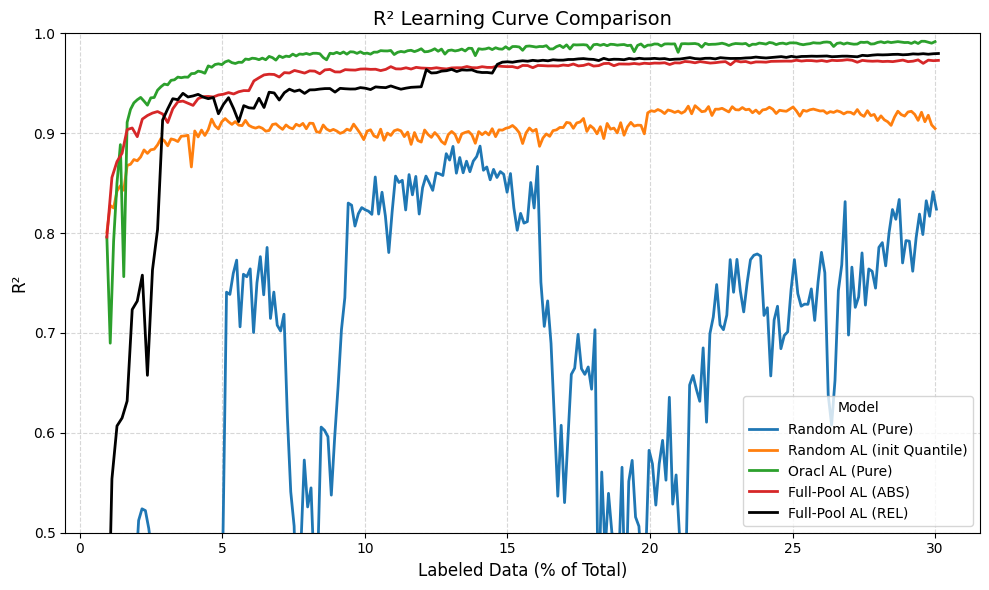

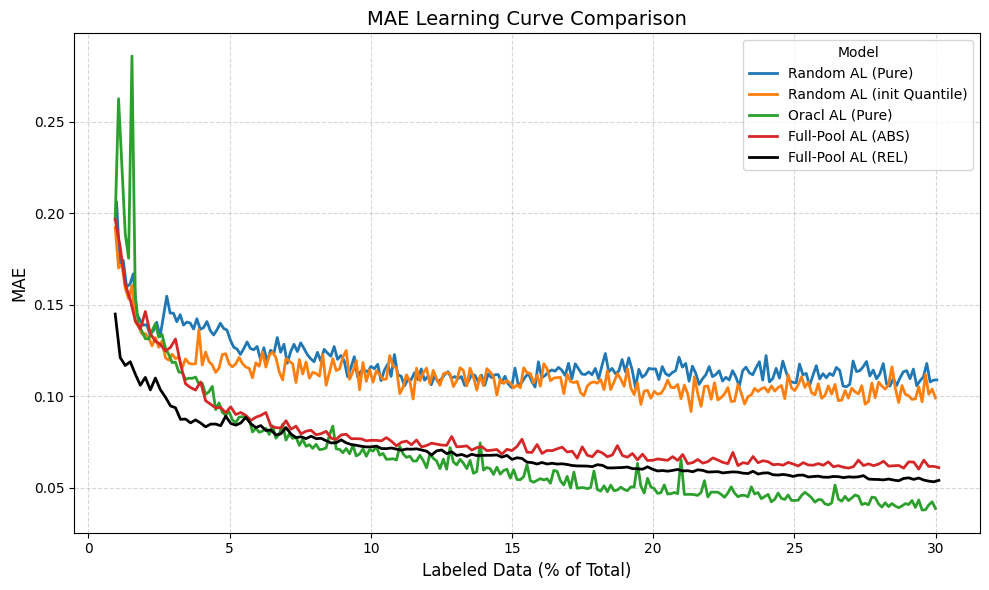

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ── Load Data ─────────────────────────────────────────
cases = {
    "Random AL (Pure)": "[Ar_05bar_5bar_Random]AL_Random_20250420_162807/active_learning_metrics_random.csv",
    "Random AL (init Quantile)": "[Ar_05bar_5bar_Random_SAMPLING_INIT_QUANTILE]AL_Random_20250420_160849/active_learning_metrics_random.csv",
    "Oracl AL (Pure)": "[Ar_05bar_5bar_Oracle]AL_Oracle_20250420_154919/active_learning_metrics_oracle.csv",
    "Full-Pool AL (ABS)": "[Ar_05bar_5bar_AL]AL_20250420_153305/active_learning_metrics.csv",
    "Full-Pool AL (REL)": "[Ar_REL_05bar_5bar_AL]AL_20250420_165510/active_learning_metrics.csv",
    "Full-Pool AL (ABS + Priority)": "[Ar_05bar_5bar_AL_Priority]AL_20250420_173339/active_learning_metrics.csv"
}

# Read metrics
dfs = {label: pd.read_csv(path) for label, path in cases.items()}

# Determine total for percentage
total_samples = len(X_all)

# Origin-style colors & markers
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 'black', 'purple']

# ── Plot R² as Scatter ─────────────────────────────────
plt.figure(figsize=(10, 6))
for (model, df), color in zip(dfs.items(), colors):
    pct = df['n_labeled'] * 100 / total_samples
    plt.plot(pct, df['r2'],
             color=color,
             linestyle='-',
            #  marker=marker,
             linewidth=2,
            #  markersize=8,
             label=f"{model}")
plt.xlabel("Labeled Data (% of Total)", fontsize=12)
plt.ylabel("R²", fontsize=12)
plt.title("R² Learning Curve Comparison", fontsize=14)
plt.legend(title="Model", loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0.5, 1)
plt.tight_layout()
plt.show()

# ── Plot MAE as Line ──────────────────────────────────
plt.figure(figsize=(10, 6))
for (model, df), color,  in zip(dfs.items(), colors, ):
    pct = df['n_labeled'] * 100 / total_samples
    plt.plot(pct, df['mae'],
             color=color,
             linestyle='-',
            #  marker=marker,
             linewidth=2,
            #  markersize=8,
             label=f"{model}")
plt.xlabel("Labeled Data (% of Total)", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.title("MAE Learning Curve Comparison", fontsize=14)
plt.legend(title="Model", loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Test Data 그리는 gif 코드

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm

# ── 파일 경로 설정 ──────────────────────────────
dir1 = "./[Ar_05bar_5bar_AL]AL_20250420_153305/predictions/"
dir2 = "./[Ar_REL_05bar_5bar_AL]AL_20250420_165510/predictions/"
csvs1 = sorted([f for f in os.listdir(dir1) if f.endswith(".csv")])
csvs2 = sorted([f for f in os.listdir(dir2) if f.endswith(".csv")])

# 모든 데이터 로드하여 전체 범위 확인
df1_all = pd.concat([pd.read_csv(os.path.join(dir1, f)) for f in csvs1])
df2_all = pd.concat([pd.read_csv(os.path.join(dir2, f)) for f in csvs2])
global_min = min(df1_all['y_true'].min(), df1_all['y_pred'].min(), df2_all['y_true'].min(), df2_all['y_pred'].min())
global_max = max(df1_all['y_true'].max(), df1_all['y_pred'].max(), df2_all['y_true'].max(), df2_all['y_pred'].max())

# ── 이미지 저장 폴더 ─────────────────────────────
img_dir = "./comparison_gif_frames"
os.makedirs(img_dir, exist_ok=True)

filenames = []
for csv1, csv2 in tqdm(zip(csvs1, csvs2), total=min(len(csvs1), len(csvs2))):
    df1 = pd.read_csv(os.path.join(dir1, csv1))
    df2 = pd.read_csv(os.path.join(dir2, csv2))

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(df1['y_true'], df1['y_pred'], alpha=0.6, label='ABS AL', color='blue')
    ax.scatter(df2['y_true'], df2['y_pred'], alpha=0.6, label='REL AL', color='red')
    ax.plot([global_min, global_max], [global_min, global_max], 'k--', lw=1)
    ax.set_title(f"Iteration {csv1.split('_')[-1].split('.')[0]}")
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(global_min, global_max)
    ax.legend()
    ax.grid(True)

    frame_path = os.path.join(img_dir, f"{csv1.split('_')[-1].split('.')[0]}.png")
    plt.savefig(frame_path)
    filenames.append(frame_path)
    plt.close()

# ── GIF 생성 ─────────────────────────────
gif_path = "comparison.gif"
filenames = sorted(filenames, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

with imageio.get_writer(gif_path, mode='I', duration=100) as writer:  # 1초 per frame
    for filename in filenames:
        image = imageio.v2.imread(filename)
        writer.append_data(image)

print("✅ Sorted GIF saved at:", gif_path)


100%|██████████| 165/165 [00:43<00:00,  3.77it/s]


✅ Sorted GIF saved at: comparison.gif
